In [35]:
%autosave 120

Autosaving every 120 seconds


# HyperParameter Optimizer Notebook

This notebook tries to find the best hyperparameter to use for the CNN multilabel classifier

In [36]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2867608201077687820
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11139884032
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 12443046583895028497
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:89:00.0, compute capability: 3.7"
]
Num GPUs Available:  1


In [37]:
from glob import glob

import pickle 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

In [38]:
mpl.rc('font', size=14)

## Input Spectra

Input DESI spectra generated from the pickle notebook. Then divide them into training and test sets for the classifier.

In [39]:
with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [40]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [41]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [42]:
with open('snic_flux.data', 'rb') as filehandle:
    snic_flux = pickle.load(filehandle)

In [43]:
with open('sniin_flux.data', 'rb') as filehandle:
    sniin_flux = pickle.load(filehandle)

In [44]:
with open('sniip_flux.data', 'rb') as filehandle:
    sniip_flux = pickle.load(filehandle)

In [45]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
# nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
# nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape

# nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins
nhost, nsnia, nsnib, nsnic, nsniin, nsniip, nbins

(9969, 9964, 9958, 8269, 9949, 9962, 150)

### Set up Training Sets and Labels

0. "host" spectra based only on BGS templates
0. "snia" spectra based on BGS + SN Ia templates
0. "snib" spectra based on BGS + SN Ib templates
0. "snic" spectra based on BGS + SN Ic templates
0. "sniin" spectra based on BGS + SN IIn templates
0. "sniip" spectra based on BGS + SN IIP templates

In [46]:
x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snic_flux,
                    sniin_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ic',
          'SN IIn',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnic, 3),
                        np.full(nsniin, 4),
                        np.full(nsniip, 5)
                       ]))

In [47]:
x.shape, y.shape

((58071, 150, 1), (58071, 6))

## HyperModel setup

Build a hypermodel which for tuner search

In [48]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, GlobalAvgPool1D,AvgPool1D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_normal, glorot_uniform

In [49]:
def model_builder(hp):
    
  seed=None

  inputs =Input(shape=(nbins,1))
  x = inputs
    
  for i in range(hp.Int('conv_blocks', 4, 6, default=5)): #change from 5 to 4
    filters = hp.Int('filters_' + str(i), 32, 512, step=32)
    for _ in range(2):
      x = Conv1D(filters, kernel_size=5, padding='same',kernel_regularizer=regularizers.l2(0.05))(x)
      x = BatchNormalization(axis=2)(x)
      x = Activation('relu')(x)
      x = Conv1D(filters, kernel_size=5, padding='same',kernel_regularizer=regularizers.l2(0.05))(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = MaxPooling1D()(x)
    else:
      x = AvgPool1D()(x)
  x = GlobalAvgPool1D()(x)
  x = Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
  x = Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = Dense(6, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.compile(
    optimizer=Adam(
      hp.Float('learning_rate', 1e-5, 1, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model


### Organizing the training Data
Split the data into training and testing (+ validation) samples and fit the network weights.

In [50]:
from sklearn.model_selection import train_test_split

def train_test_validate(x, y, train_size=0.75, test_size=0.125, val_size=0.125):
    # Ensure proper normalization.
    if train_size + test_size + val_size != 1:
        norm = train_size + test_size + val_size
        train_size = train_size/norm
        test_size = test_size/norm
        val_size = val_size/norm
        print('Renormalized to train {:g}, test {:g}, and validate {:g}'.format(train_size, test_size, val_size))
        
    # Split into training and testing samples.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size)
    
    # Split off the validation sample from the test sample.
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size+val_size))
    
    return x_train, x_test, x_val, y_train, y_test, y_val

In [51]:
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validate(x, y, 0.6, 0.2, 0.2)

x_train.shape, x_test.shape, x_val.shape

((34842, 150, 1), (11615, 150, 1), (11614, 150, 1))

### HyperParamater Optimization

In [52]:
import kerastuner as kt
from  kerastuner import Hyperband
from kerastuner.applications import HyperResNet


tuner = Hyperband(model_builder,objective='val_accuracy', max_epochs=30, project_name='Optimal_CNN3')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

INFO:tensorflow:Reloading Oracle from existing project ./Optimal_CNN3/oracle.json
INFO:tensorflow:Reloading Tuner from ./Optimal_CNN3/tuner0.json


In [53]:
hyperopt = tuner.search(x_train, y_train,epochs=20,validation_data=(x_test, y_test),
             callbacks=[stop_early])

Trial 38 Complete [00h 11m 35s]
val_accuracy: 0.17615152895450592

Best val_accuracy So Far: 0.7386138439178467
Total elapsed time: 09h 34m 03s
INFO:tensorflow:Oracle triggered exit


In [ ]:
hyperopt

### Optimal hyperparameters

In [54]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is and the optimal learning rate for the optimizer
is 1.8225460564333567e-05.



In [55]:
models = tuner.get_best_models(num_models=2)

In [56]:
hypermodel = tuner.hypermodel.build(best_hps)

In [69]:
hypermodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 480)          2880      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 480)          1920      
_________________________________________________________________
activation (Activation)      (None, 150, 480)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 480)          1152480   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 480)          1152480   
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 480)          1920  

In [57]:
hypermodel.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 150, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 480,
    'kernel_size': (5,),
    'strides': (1,),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L2',
     'config': {'l2': 0.05000000074505806}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1d',
   'inbound_nodes': [[['input_1', 0, 

In [70]:
hist = hypermodel.fit(x_train, y_train,epochs=50,validation_data=(x_test, y_test),
             callbacks=[stop_early]
                     )

Epoch 1/50
1089/1089 [==============================] - 176s 162ms/step - loss: 0.9480 - accuracy: 0.7876 - val_loss: 1.2082 - val_accuracy: 0.7024
Epoch 2/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.9377 - accuracy: 0.7914 - val_loss: 1.3744 - val_accuracy: 0.6529
Epoch 3/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.9325 - accuracy: 0.7902 - val_loss: 1.1572 - val_accuracy: 0.7021
Epoch 4/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.9226 - accuracy: 0.7945 - val_loss: 1.2392 - val_accuracy: 0.6746
Epoch 5/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.9159 - accuracy: 0.7970 - val_loss: 1.0781 - val_accuracy: 0.7336
Epoch 6/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.9081 - accuracy: 0.8010 - val_loss: 1.1402 - val_accuracy: 0.7173
Epoch 7/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.9031 - accuracy: 0.7986 - val_

In [71]:
hypermodel.save('6label_cnn_restframe')

INFO:tensorflow:Assets written to: 6label_cnn_restframe/assets


In [72]:
hypermodel.save('6label_cnn_restframe.h5')

In [73]:
hypermodel.loss

'categorical_crossentropy'

In [74]:
hypermodel.optimizer

In [75]:
K.eval(hypermodel.optimizer.lr)

1.822546e-05

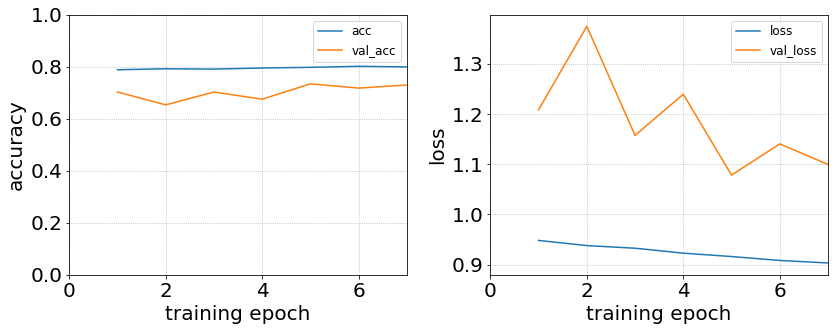

In [80]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();
fig.savefig('6label_acc_loss.png', dpi=120)


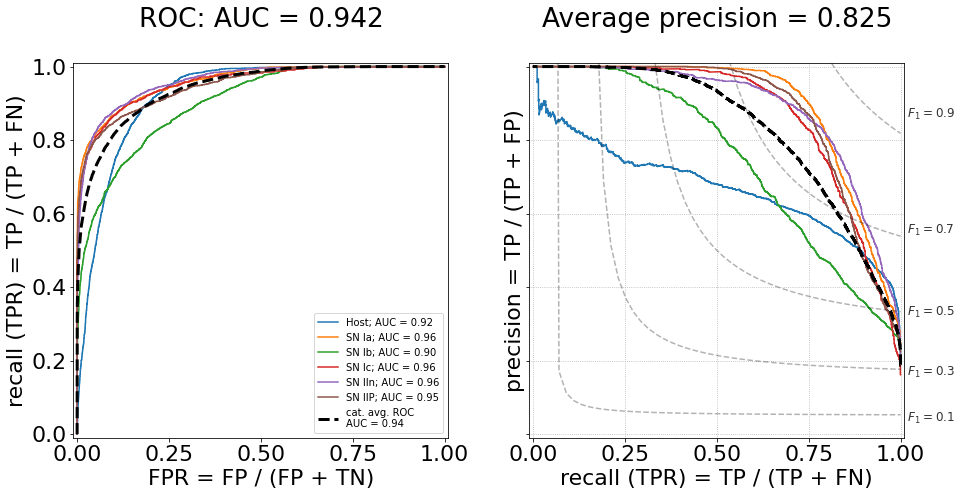

In [81]:

### ROC Curve and Precision-Recall

# Plot both the ROC curves per class and the class-averaged ROC curve.

y_pred = hypermodel.predict(x_val)
y_pred

mpl.rc('font', size=22)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(14,7), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}\n'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}\n'.format(average_precision_score(y_val, y_pred)),
       aspect='equal')

fig.tight_layout()
# fig.savefig('6label_roc_pr.png', dpi=120)

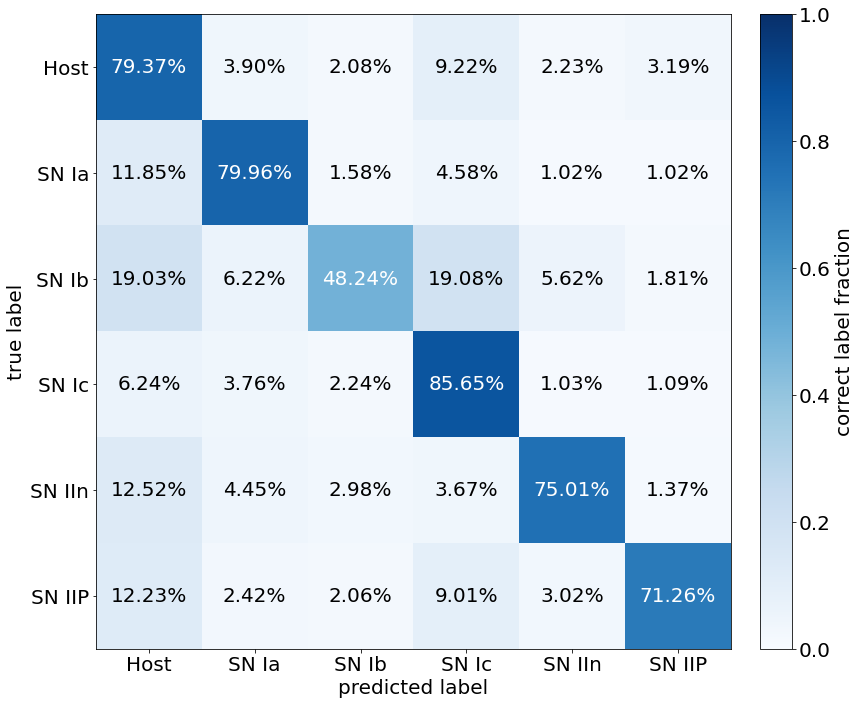

In [82]:
### Confusion Matrix

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

mpl.rc('font', size=20)

fig, ax = plt.subplots(1,1, figsize=(1.2*10,1.2*8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
#         ax.text(j, i, '{:.3f}\n({:d})'.format(100*cmnorm[i,j], cm[i,j]),
#                 ha='center', va='center',
#                 color='black' if cm[i,j] < thresh else 'white')
            ax.text(j, i, '{:.2f}%'.format(100*cmnorm[i,j]),
                            ha='center', va='center',
                            color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm.png', dpi=120)

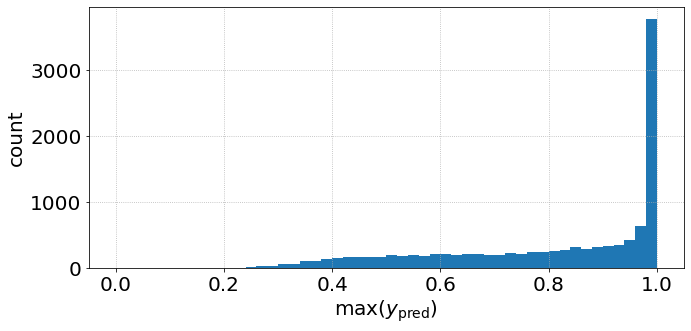

In [83]:
# Cut 
i = np.argmax(y_pred, axis=1)
y_max = np.max(y_pred, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.hist(y_max, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count')
ax.grid(ls=':')
fig.savefig('max_ypred.png', dpi=120)

np.sum(y_max > 0.95) / len(y_max)

select = y_max > 0.99

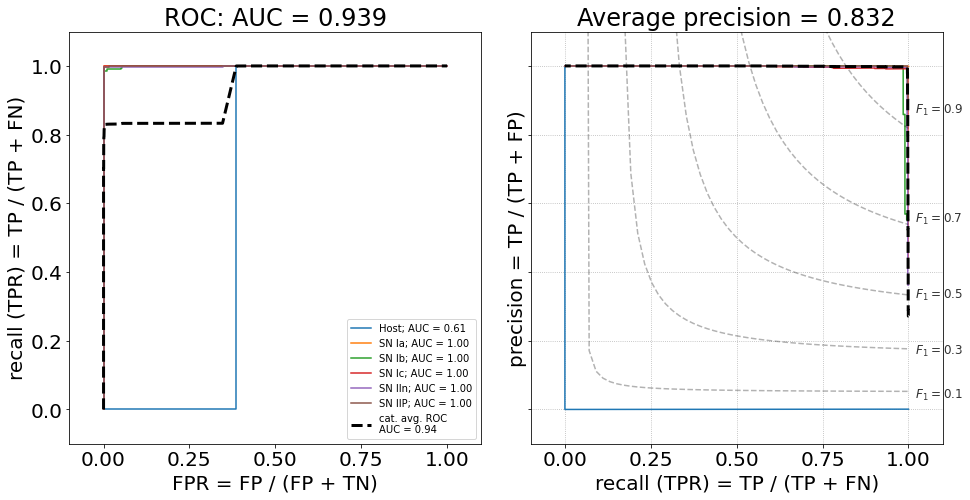

In [84]:
# New roc curve
fig, axes = plt.subplots(1,2, figsize=(14,7), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[select][:,i], y_pred[select][:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[select][:,i], y_pred[select][:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.1,1.1), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.1,1.1), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val[select].ravel(), y_pred[select].ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlim=(-0.1,1.1),xlabel='recall (TPR) = TP / (TP + FN)',
       ylim=(-0.1,1.1),ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val[select], y_pred[select])),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr_y99.png', dpi=120)


(11614, 8525)

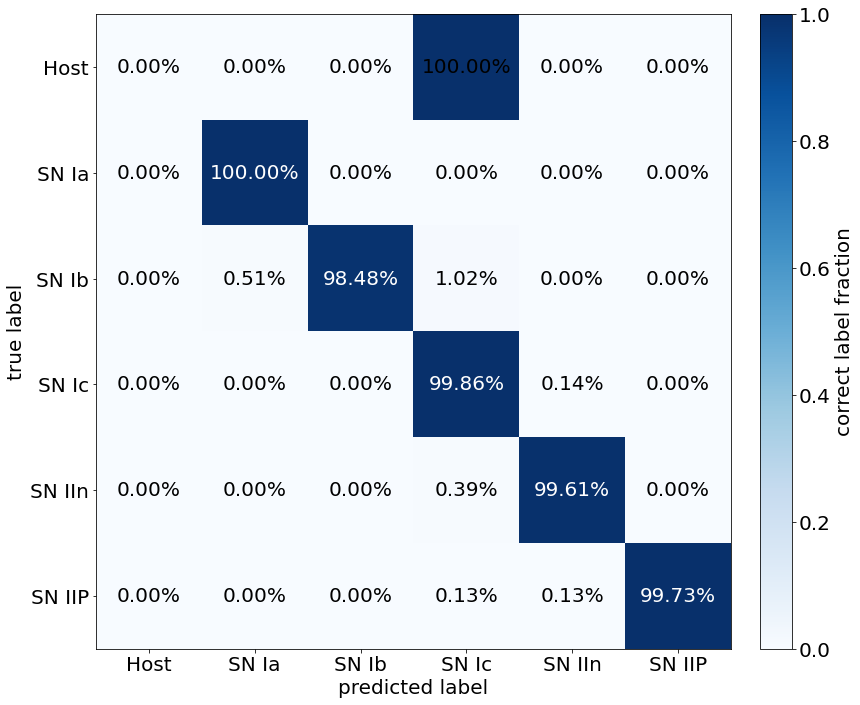

In [85]:
# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val[select].argmax(axis=1), y_pred[select].argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10*1.2,1.2*8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

# thresh = 0.5*cm.max()
thresh = np.average(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.2f}%'.format(100*cmnorm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')


fig.tight_layout()
fig.savefig('6label_cm_ygt0.99.png', dpi=120)

len(y_pred), len(y_pred) - np.sum(select)

In [86]:
# without stopping

In [ ]:
hist = hypermodel.fit(x_train, y_train,epochs=50,validation_data=(x_test, y_test),
#              callbacks=[stop_early]
                     )

Epoch 1/50
1089/1089 [==============================] - 176s 162ms/step - loss: 0.8948 - accuracy: 0.8036 - val_loss: 1.1608 - val_accuracy: 0.7134
Epoch 2/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.8911 - accuracy: 0.8051 - val_loss: 1.1063 - val_accuracy: 0.7316
Epoch 3/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.8797 - accuracy: 0.8078 - val_loss: 1.2293 - val_accuracy: 0.7000
Epoch 4/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.8763 - accuracy: 0.8096 - val_loss: 1.2816 - val_accuracy: 0.6779
Epoch 5/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.8662 - accuracy: 0.8114 - val_loss: 1.1946 - val_accuracy: 0.7046
Epoch 6/50
1089/1089 [==============================] - 177s 163ms/step - loss: 0.8584 - accuracy: 0.8159 - val_loss: 1.2467 - val_accuracy: 0.6899
Epoch 7/50
1089/1089 [==============================] - 177s 162ms/step - loss: 0.8542 - accuracy: 0.8187 - val_

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();
fig.savefig('6label_acc_loss.png', dpi=120)


In [ ]:
### Confusion Matrix

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

mpl.rc('font', size=20)

fig, ax = plt.subplots(1,1, figsize=(1.2*10,1.2*8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
#         ax.text(j, i, '{:.3f}\n({:d})'.format(100*cmnorm[i,j], cm[i,j]),
#                 ha='center', va='center',
#                 color='black' if cm[i,j] < thresh else 'white')
            ax.text(j, i, '{:.2f}%'.format(100*cmnorm[i,j]),
                            ha='center', va='center',
                            color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm.png', dpi=120)